# Дано:

$x$, м — координата точки
$t$, с — время (от 0 до 14400 с).
$S(x,t)$ — доля объёма пор, занятых водой
$i = 1$ — исходно насыщающая пласт жидкость
$i = 2$ — закачиваемая жидкость
$m = 0.3$ — коэффициент пористости
$k_i$ и $\mu_i = const$ — коэффициенты относительной фазовой проницаемости и динамической вязкости соответственно.

Принять, что соотношение коэффициентов $k_1/k_2$ равно соотношению насыщенности жидкостей

$$
\frac{k_1}{k_2} = \frac{S_1}{S_2}
$$

Динамическая вязкость для исходно насыщающей пласт жидкости в два раза больше, чем для закачиваемой жидкости:

$$
\frac{\mu_1}{\mu_2} = 2
$$

Линейный закон фильтрации:

$$
u_i = - \frac{k_i}{\mu_i} \nabla p
$$

Суммарная скорость фильтрации двух жидкостей $u_1 + u_2$ постоянна и равна $0.1 \frac{\text{мм}}{\text{с}}$:

$$
u_1 + u_2 = 0.0001 = u
$$

Принять, что при совместном течении в пористом пласте нескольких несмешивающихся жидкостей величина насыщенности $S_i$ для каждой жидкости связана со скоростью фильтрации $u_i$ следующим соотношением:

$$
m \frac{\partial S_i}{\partial t} = - \text{div}\; u_i
$$

# Решение


(1)
$$
u_1 = - \frac{k_1}{\mu_1} \frac{\partial p}{\partial x}
$$

(2)
$$
u_2 = - \frac{k_2}{\mu_2} \frac{\partial p}{\partial x}
$$

(3)
$$
m \frac{\partial S_1}{\partial t} = - \frac{\partial u_1}{\partial x}
$$

(4)
$$
m \frac{\partial S_2}{\partial t} = - \frac{\partial u_2}{\partial x}
$$

(1)/(2)

(5)

$$
\frac{u_1}{u_2} = \frac{k_1}{k_2} \frac{\mu_2}{\mu_1} = \frac{S_1}{2 S_2}
$$

(6)
$$
u_1 + u_2 = 0.0001 = u
$$

Система нелинейных алгебраических уравнений $(5) - (6)$ может быть решена аналитически или численно методом Ньютона на каждом шаге по времени.

Так как в системе только две жидкости, их суммарная насыщенность всегда равна $1$, то есть

(7)
$$
S_1 + S_2 = 1
$$.

Поэтому уравнение $(3)$ можно не решать ввиду его избыточности.

Решаем уравнение $(4)$:

$$
m \frac{\partial S_2}{\partial t} = - \frac{\partial u_2}{\partial x}
$$

Из $(5)$, $(6)$ $(7)$
$$
S_1 + S_2 = 1 \leftrightarrow S_1 = 1 - S_2
$$

$$
\frac{u_1}{u_2} = \frac{S_1}{2 S_2} \leftrightarrow u_1 \cdot 2 \cdot S_2 = S_1 \cdot u_2
$$

$$
u_1 + u_2 = u \leftrightarrow u_1 = u - u_2
$$

Оставляем выражение для $u_2$:

$$
(u - u_2) \cdot 2 \cdot S_2 = (1 - S_2) \cdot u_2 \leftrightarrow u_2 = \frac{2 u S_2}{1 + S_2}
$$

Получаем уравнение относительно $S = S_2$ следующего вида:
$$
\begin{cases}
m \frac{\partial S}{\partial t} + \frac{2 u \frac{\partial S}{\partial x}}{1 + S} - \frac{2 u S \frac{\partial S}{\partial x}}{(1 + S)^2} = 0 \\
S_2 (x = 10) = 1 \\
S_2 (t = 0) = \begin{cases}
0, x < 10 \\
1, x = 10
\end{cases}
\end{cases}
$$

In [1]:
from scipy import optimize
import numpy as np

max_time = float(3600*4)
max_x = float(10)

nx, nt = 100, 100
hx, ht = max_x / float(nx - 1), max_time / float(nt - 1)

m = 0.3
u = -0.0001

print(abs(u) * ht / hx)

kolgan = True

0.14400000000000002


In [2]:
P_right = 1
P_bottom = 0

In [3]:
def minmod(a, b):
   return 0.5*(np.sign(a) + np.sign(b))*np.minimum(np.abs(a), np.abs(b))

def residual(S):
   d1x = np.zeros_like(S)
   d1t = np.zeros_like(S)

   if not kolgan:
     d1x[0:-1] = (S[1:] - S[0:-1]) / hx
   else:
     d1x[0] = (S[1] - S[0]) / hx
     d1x[1:-2] = (S[2:-1] - S[1:-2]) / hx  - (minmod((S[3:] - S[2:-1]) / hx, (S[2:-1] - S[1:-2]) / hx)  - minmod((S[2:-1] - S[1:-2]) / hx, (S[1:-2] - S[0:-3]) / hx))/2.0
   d1x[-2] = (S[-1] - S[-2]) / hx
   d1x[-1] = (P_right - S[-1]) / hx

   d1t[:,0] = (S[:, 0] - P_bottom) / ht
   d1t[:,1:] = (S[:, 1:] - S[:, 0:-1]) / ht

   return m * d1t + (2* u * d1x) / (1.0 + S) - (2* u * S * d1x) / ((1.0 + S) ** 2)

In [4]:
minmod(np.array([1, 2, 3]), np.array([-1,3,-1]))

array([0., 2., 0.])

In [5]:
guess = np.zeros((nx, nt), float)
guess[-1, :] = 1

In [6]:
sol = optimize.root(residual, guess, method='krylov')

In [7]:
print('Residual: %g' % abs(residual(sol.x)).max())

Residual: 1.87798e-06


In [8]:
import matplotlib.pyplot as plt

In [9]:
x, y = np.mgrid[0:max_x:(nx*1j), 0:max_time:(nt * 1j)]

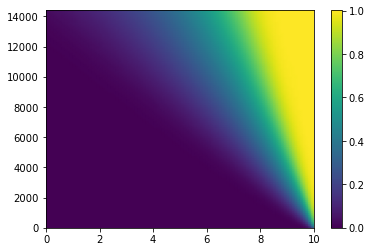

In [10]:
plt.pcolormesh(x, y, sol.x, shading='gouraud')
plt.colorbar()
plt.show()

In [11]:
with open("solution.txt", "w") as text_file:
   text_file.write("\n".join([f"{a}\t{b}" for a, b in zip(x[:,-1], sol.x[:,-1])]))

In [12]:
Ss = np.linspace(1,0,num=101)

m = 0.3
mu = 1/2
u_inj = -0.0001
x_0 = 10

def f(S, t):
    return (S**2*m*mu**2*x_0 - 2*S**2*m*mu*x_0 - 2*S*m*mu**2*x_0 + S**2*m*x_0 + 2*S*m*mu*x_0 + m*mu**2*x_0 + mu*t*u_inj)/((S*mu - S - mu)**2*m)

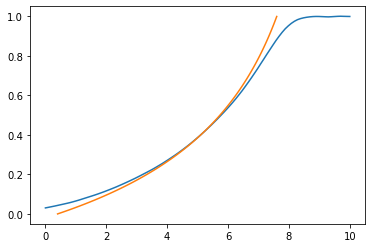

In [13]:
plt.plot(x[:,-1],sol.x[:,-1])
plt.plot(np.array(list(map(lambda S: f(S, t=14400), Ss))),Ss)